In [48]:
# On exécute pip install openpyxl dans le terminal
import pandas as pd
import sqlite3

def création_bdd(type_score):
    df1 = pd.read_csv('ValueCo Industrials Europe coverage.csv')
    df2 = pd.read_csv('Controversies Results Feb 24 2025.csv')
    df2_filtré = df2[df2['Client_ID'].isin(df1['isin'])]
    df3 = pd.read_excel('Controversy data documentation.xlsx')
    
    # On filtre par 'Pillar Tags'
     #  df3_filtré=df3[df3['Pillar Tags']==type_score]
    df3_filtré=df3[df3['Pillar Tags'].apply(lambda x:type_score in str(x))]
    
    # On vérifie si la colonne 'Factor Column Header' existe dans le DataFrame filtré
    if not df3_filtré.empty:
        l_colonnes = df3_filtré['Factor Column Header'].tolist()
    else:
        print(f"Aucune ligne trouvée pour le type de score {type_score}")
        return
    
    l_colonnes_complet = ["Client_ID"] + l_colonnes
    
    # On filtre df2 avec les colonnes nécessaires
    df2_filtréx2 = df2_filtré[l_colonnes_complet]
    df2_filled = df2_filtréx2.fillna(0)
    df2_filled = df2_filled.loc[:, ~(df2_filled == 0.0).all()]
    return df2_filled


In [49]:
def bdd_diff_consensus(type_score):
    df = pd.read_csv('BQ Results Apr 8 2025.csv')
    df['period'] = pd.to_datetime(df['period'], errors='coerce')
    
    df_filtré = df[df['score_kind'] == type_score]
    
    start_date = pd.to_datetime('2025-01-01')
    end_date = pd.to_datetime('2025-03-01')
    
    df_filtré = df_filtré[df_filtré['period'].isin([start_date, end_date])]
    
    # Pivot pour avoir une colonne par date
    pivot = df_filtré.pivot(index='isin', columns='period', values='consensus')
    
    # Calcul de la différence
    pivot['Diff'] = pivot[end_date] - pivot[start_date]
    
    # On garde seulement la différence
    pivot = pivot[['Diff']].reset_index()
    
    return pivot


In [50]:
import pandas as pd
import statsmodels.api as sm

def reg_lin(type_score):
    # Chargement des données principales
    df1 = création_bdd(type_score)  
    df2 = bdd_diff_consensus(type_score[0]) 
    
    # Harmonisation du nom de clé
    df1 = df1.rename(columns={'Client_ID': 'isin'})

    # Fusion des bases
    df_merged = pd.merge(df1, df2, on='isin')
    
    x=df_merged.drop(columns=['isin','Diff'])

    # Vérification que X n'est pas vide ou 100% NaN
    if x.dropna(how='all').empty:
        print("❌ Les variables explicatives sont vides ou entièrement nulles.")
        return

    x= sm.add_constant(x)

    y = df_merged['Diff']

    if y.isnull().all():
        print("❌ La variable dépendante 'Diff' est entièrement vide.")
        return

    # Régression linéaire
    model = sm.OLS(y, x).fit()
    print(model.summary())

In [51]:
reg_lin('Governance')

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     12.75
Date:                Fri, 09 May 2025   Prob (F-statistic):           7.66e-17
Time:                        12:20:37   Log-Likelihood:                 44.484
No. Observations:                 276   AIC:                            -68.97
Df Residuals:                     266   BIC:                            -32.76
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [53]:
reg_lin('Environment')

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                  0.001533
Date:                Fri, 09 May 2025   Prob (F-statistic):               1.00
Time:                        12:20:53   Log-Likelihood:                 222.32
No. Observations:                 276   AIC:                            -430.6
Df Residuals:                     269   BIC:                            -405.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [54]:
reg_lin('Social')

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.638
Date:                Fri, 09 May 2025   Prob (F-statistic):           1.51e-05
Time:                        12:20:58   Log-Likelihood:                 707.66
No. Observations:                 276   AIC:                            -1349.
Df Residuals:                     243   BIC:                            -1230.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [55]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reg_ridge_lasso(type_score):
    df1 = création_bdd(type_score)  
    df2 = bdd_diff_consensus(type_score[0]) 

    df1 = df1.rename(columns={'Client_ID': 'isin'})
    df_merged = pd.merge(df1, df2, on='isin')

    X = df_merged.drop(columns=['isin', 'Diff'])
    y = df_merged['Diff']

    # Vérifications
    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    # Prétraitement : imputation et standardisation
    X = X.fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Ridge regression avec validation croisée
    ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5).fit(X_scaled, y)
    print("✅ Ridge Regression")
    print(f"Meilleur alpha : {ridge.alpha_}")
    print(f"Score R² : {ridge.score(X_scaled, y)}\n")

    # Lasso regression avec validation croisée
    lasso = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, max_iter=10000).fit(X_scaled, y)
    print("✅ Lasso Regression")
    print(f"Meilleur alpha : {lasso.alpha_}")
    print(f"Score R² : {lasso.score(X_scaled, y)}")

    # Optionnel : Affichage des coefficients non nuls (Lasso = sélection de variables)
    coef = pd.Series(lasso.coef_, index=X.columns)
    print("\nVariables sélectionnées par Lasso :")
    print(coef[coef != 0])

     # Visualisation des coefficients
    plt.figure(figsize=(12, 6))

    # Ridge coefficients
    ridge_coef = pd.Series(ridge.coef_, index=X.columns)
    ridge_coef.plot(kind='bar', color='skyblue', label='Ridge Coefficients', alpha=0.7)

    # Lasso coefficients
    lasso_coef = pd.Series(lasso.coef_, index=X.columns)
    lasso_coef.plot(kind='bar', color='salmon', label='Lasso Coefficients', alpha=0.7)

    plt.title("Comparaison des coefficients Ridge vs Lasso")
    plt.ylabel("Poids des variables")
    plt.xlabel("Variables explicatives")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Affichage de la performance
    print("\n✅ Visualisation des performances :")
    print(f"Ridge R² : {ridge.score(X_scaled, y):.4f}")
    print(f"Lasso R² : {lasso.score(X_scaled, y):.4f}")

    return ridge, lasso

In [56]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def reg_ridge_lasso(type_score):
    df1 = création_bdd(type_score)  
    df2 = bdd_diff_consensus(type_score[0]) 

    df1 = df1.rename(columns={'Client_ID': 'isin'})
    df_merged = pd.merge(df1, df2, on='isin')

    X = df_merged.drop(columns=['isin', 'Diff'])
    y = df_merged['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    # Imputation et standardisation
    X = X.fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # RidgeCV
    ridge_alphas = np.logspace(-6, 6, 100)
    ridge = RidgeCV(alphas=ridge_alphas, cv=5, scoring='r2').fit(X_scaled, y)
    ridge_cv_score = cross_val_score(ridge, X_scaled, y, cv=5, scoring='r2')

    # LassoCV
    lasso_alphas = np.logspace(-6, 1, 100)
    lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=50000, tol=1e-4).fit(X_scaled, y)
    lasso_cv_score = cross_val_score(lasso, X_scaled, y, cv=5, scoring='r2')

    # Résultats Ridge
    print("✅ Ridge Regression")
    print(f"Meilleur alpha : {ridge.alpha_:.6f}")
    print(f"R² entraînement : {ridge.score(X_scaled, y):.4f}")
    print(f"R² validation croisée : {ridge_cv_score.mean():.4f} ± {ridge_cv_score.std():.4f}")

    # Résultats Lasso
    print("\n✅ Lasso Regression")
    print(f"Meilleur alpha : {lasso.alpha_:.6f}")
    print(f"R² entraînement : {lasso.score(X_scaled, y):.4f}")
    print(f"R² validation croisée : {lasso_cv_score.mean():.4f} ± {lasso_cv_score.std():.4f}")

    # Coefficients
    ridge_coef = pd.Series(ridge.coef_, index=X.columns)
    lasso_coef = pd.Series(lasso.coef_, index=X.columns)

    # Coefficients non nuls Lasso
    print("\n📌 Variables sélectionnées par Lasso :")
    print(lasso_coef[lasso_coef != 0].sort_values(ascending=False))

    # Visualisation des coefficients
    plt.figure(figsize=(14, 6))
    ridge_coef.plot(kind='bar', alpha=0.6, label='Ridge', color='cornflowerblue')
    lasso_coef.plot(kind='bar', alpha=0.6, label='Lasso', color='salmon')
    plt.title("Comparaison des coefficients Ridge vs Lasso")
    plt.xlabel("Variables explicatives")
    plt.ylabel("Poids des coefficients")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ridge, lasso

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

✅ Ridge Regression
Meilleur alpha : 0.000001
R² entraînement : 0.3013
R² validation croisée : -0.0039 ± 0.0078

✅ Lasso Regression
Meilleur alpha : 10.000000
R² entraînement : 0.0000
R² validation croisée : -0.0039 ± 0.0078

📌 Variables sélectionnées par Lasso :
Series([], dtype: float64)


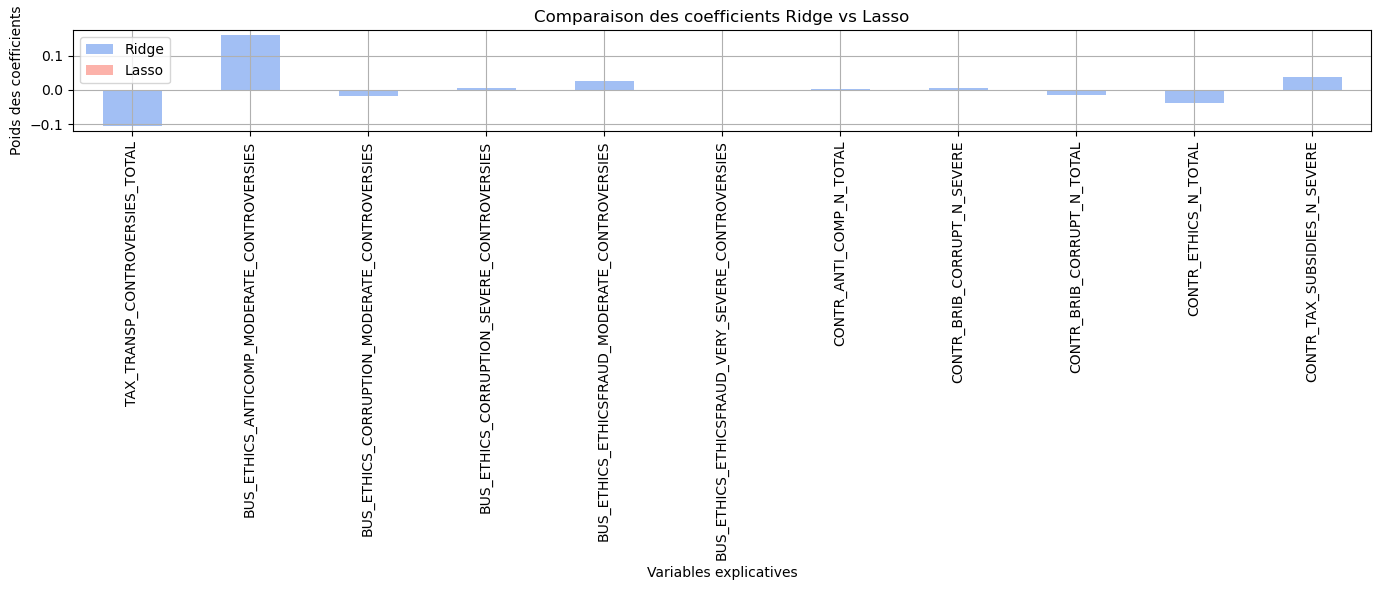

(RidgeCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06,
        3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06,
        9.32603347e-06, 1.23284674e-05, 1.62975083e-05, 2.15443469e-05,
        2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05,
        8.69749003e-05, 1.14975700e-04, 1.51991108e-04, 2.00923300e-04,
        2.65608778e-04, 3.51119173e-0...
        1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03,
        4.97702356e+03, 6.57933225e+03, 8.69749003e+03, 1.14975700e+04,
        1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04,
        4.64158883e+04, 6.13590727e+04, 8.11130831e+04, 1.07226722e+05,
        1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05,
        4.32876128e+05, 5.72236766e+05, 7.56463328e+05, 1.00000000e+06]),
         cv=5, scoring='r2'),
 LassoCV(alphas=array([1.00000000e-06, 1.17681195e-06, 1.38488637e-06, 1.62975083e-06,
        1.91791026e-06, 2.2570197

In [57]:
reg_ridge_lasso('Governance')

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

✅ Ridge Regression
Meilleur alpha : 1000000.000000
R² entraînement : 0.0000
R² validation croisée : -0.0136 ± 0.0207

✅ Lasso Regression
Meilleur alpha : 10.000000
R² entraînement : 0.0000
R² validation croisée : -0.0135 ± 0.0207

📌 Variables sélectionnées par Lasso :
Series([], dtype: float64)


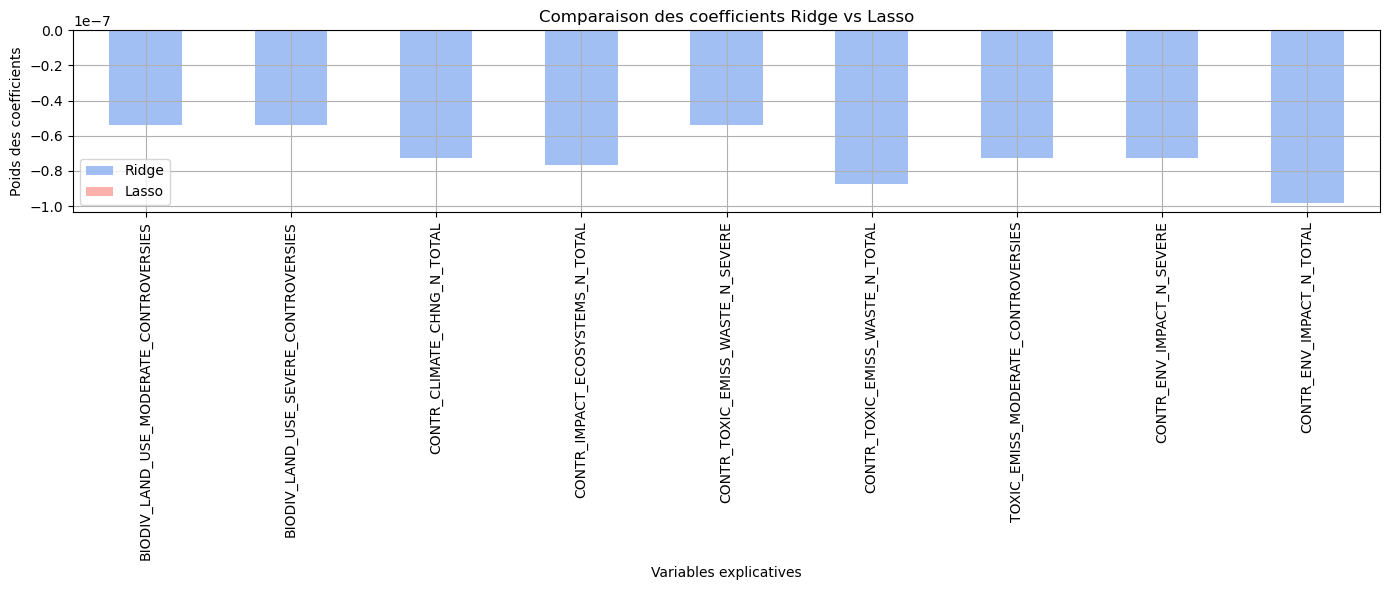

(RidgeCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06,
        3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06,
        9.32603347e-06, 1.23284674e-05, 1.62975083e-05, 2.15443469e-05,
        2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05,
        8.69749003e-05, 1.14975700e-04, 1.51991108e-04, 2.00923300e-04,
        2.65608778e-04, 3.51119173e-0...
        1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03,
        4.97702356e+03, 6.57933225e+03, 8.69749003e+03, 1.14975700e+04,
        1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04,
        4.64158883e+04, 6.13590727e+04, 8.11130831e+04, 1.07226722e+05,
        1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05,
        4.32876128e+05, 5.72236766e+05, 7.56463328e+05, 1.00000000e+06]),
         cv=5, scoring='r2'),
 LassoCV(alphas=array([1.00000000e-06, 1.17681195e-06, 1.38488637e-06, 1.62975083e-06,
        1.91791026e-06, 2.2570197

In [58]:
reg_ridge_lasso('Environment')

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

✅ Ridge Regression
Meilleur alpha : 1000000.000000
R² entraînement : 0.0001
R² validation croisée : -0.1068 ± 0.2110

✅ Lasso Regression
Meilleur alpha : 10.000000
R² entraînement : 0.0000
R² validation croisée : -0.0040 ± 0.0052

📌 Variables sélectionnées par Lasso :
Series([], dtype: float64)


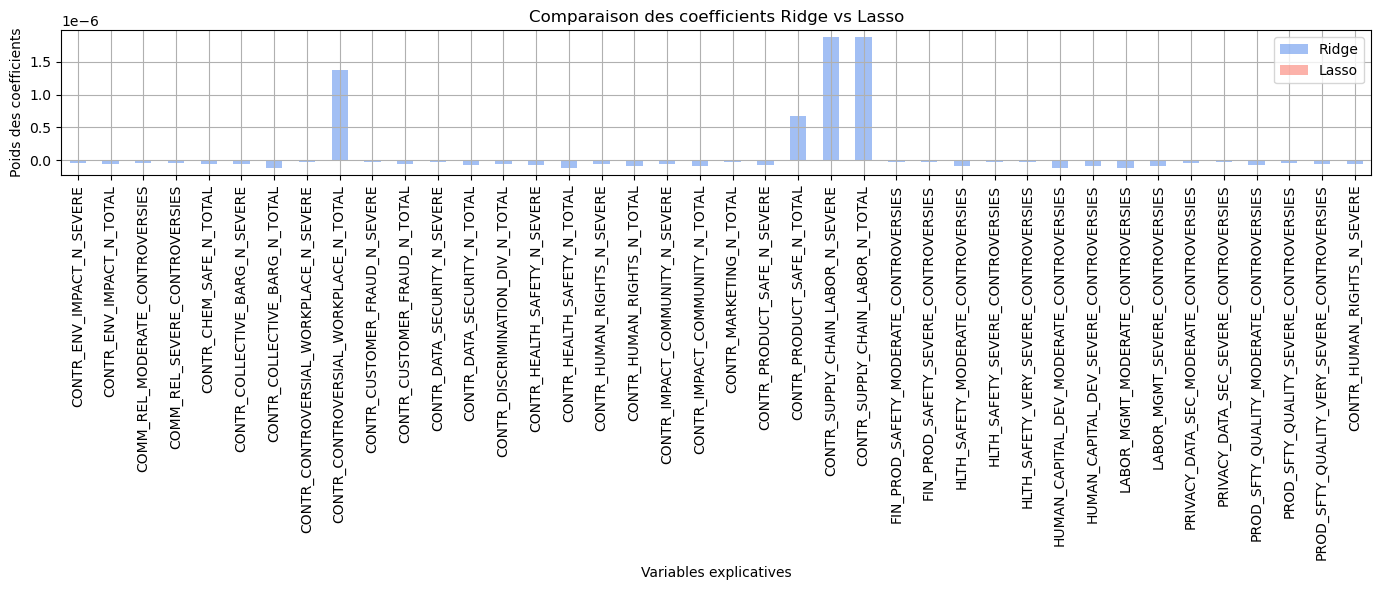

(RidgeCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06,
        3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06,
        9.32603347e-06, 1.23284674e-05, 1.62975083e-05, 2.15443469e-05,
        2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05,
        8.69749003e-05, 1.14975700e-04, 1.51991108e-04, 2.00923300e-04,
        2.65608778e-04, 3.51119173e-0...
        1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03,
        4.97702356e+03, 6.57933225e+03, 8.69749003e+03, 1.14975700e+04,
        1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04,
        4.64158883e+04, 6.13590727e+04, 8.11130831e+04, 1.07226722e+05,
        1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05,
        4.32876128e+05, 5.72236766e+05, 7.56463328e+05, 1.00000000e+06]),
         cv=5, scoring='r2'),
 LassoCV(alphas=array([1.00000000e-06, 1.17681195e-06, 1.38488637e-06, 1.62975083e-06,
        1.91791026e-06, 2.2570197

In [59]:
reg_ridge_lasso('Social')